In [78]:
# todo assuming channels are last (i.e `keras.backend.set_image_data_format('channels_last')`)

In [79]:
from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [80]:
import random
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from tifffile import imread

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Cropping2D, Dense, multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import minmax_scale
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

In [81]:
from configparser import ConfigParser

try:
    from google.colab import files
    
    print('upload `config.ini`')
    uploaded = files.upload()
except:
    print('no colab detected -> reading from local disk')

config = ConfigParser()
config.read('./config.ini')

no colab detected -> reading from local disk


['./config.ini']

In [82]:
import os
from pathlib import Path
import json
import ast

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = Path(config.get('data folder', 'colab'))
except:
  import os
  from pathlib import Path
  here = Path(os.getcwd())
  data_path = here / config.get('data folder', 'taurus')

data_path = data_path.resolve()
out_path = Path(config.get('experiment', 'output folder')).resolve()
out_path.mkdir(parents=True, exist_ok=True)
experiments_file = out_path / config.get('experiment', 'output file')

In [83]:
def load_tiff(f):
  return imread(f)


def load_image(f):
  return load_tiff(f)


def load_mask(f):
  return load_tiff(f)


def get_data(imgs_path, masks_path):
  list_imgs = [
      f
      for f in imgs_path.iterdir()
      if str(f).endswith('.tif')
  ]
  
  images = []
  masks = []
 
  for img_path in list_imgs:
    img = load_image(img_path).squeeze()
    
    mask_path = str(img_path).replace(str(imgs_path), str(masks_path)).replace('img_', 'mask_')
    mask = load_mask(mask_path)
     
    images.append(np.array(img))
    masks.append(np.array(mask))

  return images, masks

In [84]:
def normalize_transformation(feature_range):
  def _f(x):
    shape = x.shape
    x = minmax_scale(x.ravel(), feature_range=feature_range)
    x = x.reshape(shape)  # original size
    return x
  
  return _f


def crop_center_transformation(shape):
  height, width, *_ = shape  # 3rd dim not needed

  def get_start_point(dim, cropping):
    return dim // 2 - cropping // 2
  
  def get_end_point(start, cropping):
    return start + cropping
  
  def _f(img):
    y, x, *_ = img.shape  # n channels not wanted
    (start_x, start_y) = (get_start_point(x, width), get_start_point(y, height))
    (end_x, end_y) = (get_end_point(start_x, width), get_end_point(start_y, height))
    return img[start_y : end_y, start_x : end_x, ...]
  
  return _f


def rm_percentiles_transformation(min_p=0.0, max_p=100.0):
  def _f(x):
    shape = x.shape
    x = x.ravel()
    new_min, new_max = np.percentile(x, [min_p, max_p])
    x[x < new_min] = new_min
    x[x > new_max] = new_max
    return x.reshape(shape)
  
  return _f


def add_dim():
  def _f(x):
    new_dim_index = len(x.shape)
    x = np.expand_dims(x, new_dim_index)
    return x

  return _f


def compose_transformations(transformations):
  def _f(x):
    for t in transformations:
      x = t(x)
    return x
  
  return _f


def apply_transformations(lst, transformations):
  t = compose_transformations(transformations) 
  return [
    t(x) for x in lst
  ]


def do_transformations(X, y, transformations):
  X = apply_transformations(X, transformations)
  y = apply_transformations(y, transformations)
  return X, y


def parse_data(raw):
  X, y = raw
  img_shape = (config.getint('image', 'width'), config.getint('image', 'height'))
  transformations = [
    np.array,  # just in case parser did not np.array-ed
    rm_percentiles_transformation(2, 98),  # threshold outliers
    normalize_transformation((0, 1)),  # pixel values in [0, 1]
    crop_center_transformation(img_shape),
    add_dim()
  ]
  X, y = apply_transformations(X, transformations), apply_transformations(y, transformations)
  X, y = np.array(X), np.array(y)  # python list -> np.array
  return X, y

In [85]:
X, y = parse_data(
  get_data(
    data_path / config.get('data folder', 'images'),
    data_path / config.get('data folder', 'masks')
  )
)

print('X ~ {}, y ~ {}'.format(X.shape, y.shape))

X ~ (92, 252, 252, 1), y ~ (92, 252, 252, 1)


3

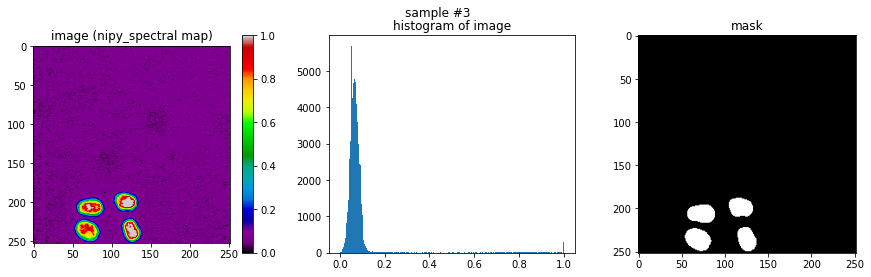

In [86]:
def plot_sample(X, y, ix=None):
  if ix is None:
    ix = random.randint(0, len(X) - 1)

  fig, ax = plt.subplots(1, 3, figsize=(15, 4))

  im = ax[0].imshow(X[ix, ..., 0], cmap=config.get('image', 'cmap'))
  fig.colorbar(im, ax=ax[0])
  ax[0].set_title('image ({} map)'.format(config.get('image', 'cmap')))

  ax[1].hist(X[ix, ...].ravel(), bins=256)
  ax[1].set_title('histogram of image')

  ax[2].imshow(y[ix].squeeze(), cmap='gray')
  ax[2].set_title('mask')

  fig.suptitle('sample #{}'.format(ix))
    
  return ix


plot_sample(X, y)  # check if data looks all right

In [87]:
def se_block(r=16.0):
  def squeeze(x):
    return GlobalAveragePooling2D()(x)
  
  def fc(n_filters, activation):
    def _f(x):
      return Dense(n_filters, activation=activation, use_bias=False)(x)
    
    return _f
  
  def excite(x, n_channels, r):
    # todo why ? se = Reshape(se_shape)(se)
    x = fc(n_channels // r, 'relu')(x)
    x = fc(n_channels, 'sigmoid')(x)
    return x

  def _f(x):
    n_channels = x.shape[-1]

    inp = x  # save for later
    x = squeeze(x)
    x = excite(x, n_channels, r)
    return multiply([inp, x])
  
  return _f

In [102]:
filter_mult = 2  # todo as arg
n_conv_layers = 2  # todo as arg


def g(n):
  if n <= 1:
    return 2
  
  return g(n - 1) * 2 + 4  # very MAGIC formula, aka 2^(n-1) + 2^(n-2) -1


def calc_crop_size(layer, conv_layers, conv_size, padding):
  if padding == 'valid':
    conv_crop = conv_layers * (conv_size - 1)
    return int(conv_crop * g(layer))
    
  return 0


def calc_out_size(n_layers, conv_layers, conv_size, pool_size, padding):
  """ calculate output size in a U-Net """
  
  conv_crop = conv_layers * (conv_size - 1)
  pool_crop = pool_size  # todo use it

  def _sub_tup(t, y):
    return (x - y for x in t)

  def _f(x):
    crop_size = calc_crop_size(n_layers, conv_layers, conv_size, padding)
    
    if padding == 'valid':
      x = _sub_tup(x, conv_crop)  # first
      x = _sub_tup(x, crop_size)  # until last concatenation
      x = _sub_tup(x, conv_crop)  # final
      x = tuple(int(_x) for _x in x)

    return x

  return _f


def conv2d_block(n_filters, kernel_shape, padding, use_se_block, dropout=0.0, batchnorm=True):
  activation = 'relu'

  def _f(x):
    for _ in range(n_conv_layers):
      x = Conv2D(n_filters, kernel_shape, padding=padding)(x)
      
      if batchnorm:
        x = BatchNormalization()(x)
      
      x = Activation(activation=activation)(x)
      
      if use_se_block:
        x = se_block()(x)

      if dropout > 0:
        x = Dropout(dropout)(x)

    return x

  return _f


def contracting_block(n_filters, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm):
  pooling = MaxPooling2D(pool_shape)

  def _f(x):
    x = conv2d_block(n_filters, kernel_shape, padding, use_se_block, dropout, batchnorm)(x)
    skip_conn = x  # save for expanding path
    x = pooling(x)  # ready for next block
    return x, skip_conn

  return _f


def contracting_path(n_filters, n_layers, kernel_shape, pool_shape, use_skip_conn, padding, use_se_block, dropout, batchnorm):
  def _f(x):
    skip_conns = []
    current_n_filters = n_filters

    for _ in range(n_layers):
      x, s = contracting_block(current_n_filters, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm)(x)
      current_n_filters = int(current_n_filters * filter_mult)
      
      if not use_skip_conn:
        s = None  # not to be used
      
      skip_conns.append(s)

    return x, skip_conns

  return _f


def middle_path(kernel_shape, padding, dropout, batchnorm):
  def _f(x):
    n_filters = int(x.shape[-1] * filter_mult)
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    return x

  return _f


def expanding_block(n_filters, skip_conn, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm):
  upsampling = UpSampling2D(pool_shape)

  def _f(x):
    if use_se_block:
      x = se_block()(x)
    
    x = upsampling(x)
    
    using_skip_conn = not (skip_conn is None)
    if using_skip_conn:
      x = concatenate([x, skip_conn])
    
    x = conv2d_block(n_filters, kernel_shape, padding, dropout, batchnorm)(x)
    return x

  return _f


def expanding_path(n_filters, skip_conns, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm):
  def _f(x):
    current_n_filters = n_filters

    for i, skip_conn in enumerate(reversed(skip_conns)):
      using_skip_conn = not (skip_conn is None)
      if using_skip_conn:
        crop_size = calc_crop_size(i + 1, n_conv_layers, kernel_shape[0], padding)
        crop_size = int(crop_size / 2)  # side by side
        skip_conn = Cropping2D(crop_size)(skip_conn)

      x = expanding_block(current_n_filters, skip_conn, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm)(x)
      current_n_filters = int(current_n_filters / filter_mult)

    return x

  return _f


def final_path(n_classes, activation, padding, use_se_block):
  def _f(x):
    if use_se_block:
      x = se_block()(x)

    x = Conv2D(n_classes, (1, 1), padding=padding, activation=activation)(x)
    return x

  return _f


def unet_block(n_filters, n_layers, kernel_shape, pool_shape, n_classes, final_activation, padding, use_skip_conn, use_se_block, dropout, batchnorm):
  def _f(x):
    x, skip_conns = contracting_path(n_filters, n_layers, kernel_shape, pool_shape, use_skip_conn, padding, use_se_block, dropout, batchnorm)(x)
    x = middle_path(kernel_shape, padding, dropout, batchnorm)(x)

    current_n_filters = skip_conns[-1].shape[-1] if use_skip_conn else n_filters * filter_mult ** (n_layers - 1)
    x = expanding_path(current_n_filters, skip_conns, kernel_shape, pool_shape, padding, use_se_block, dropout, batchnorm)(x)
    x = final_path(n_classes, final_activation, padding, use_se_block)(x)
    return x

  return _f

In [89]:
def build_unet(n_filters, n_layers, kernel_size, pool_size, n_classes, final_activation, padding='same', use_skip_conn=True, use_se_block=False, dropout=0.0, batchnorm=False):
  n_dim = 2  # todo as arg
  kernel_shape = (kernel_size, ) * n_dim
  pool_shape = (pool_size, ) * n_dim
  
  inp = Input((None, None, config.getint('image', 'depth')))
  out = unet_block(
    n_filters,
    n_layers,
    kernel_shape,
    pool_shape,
    n_classes,
    final_activation,
    padding,
    use_skip_conn,
    use_se_block,
    dropout,
    batchnorm
  )(inp)
  
  model = Model(inputs=inp, outputs=out)
  return model

In [90]:
def do_training(model, X_train, X_test, y_train, y_test, best_model_weights_file, batch_size, epochs, callbacks, compile_args):
  verbose = config.getint('experiment', 'verbose')
  
  model.compile(**compile_args)
  results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_test, y_test))
  
  return results

def do_inference(model, best_model_weights_file, data, batch_size):
  verbose = config.getint('experiment', 'verbose')
  
  model.load_weights(best_model_weights_file)
  preds_val = model.predict(data, verbose=verbose, batch_size=batch_size)
  return preds_val

In [91]:
def eps_divide(n, d, eps=K.epsilon()):
  """ perform division using eps """
    
  return (n + eps) / (d + eps)


def iou(y_true, y_pred, threshold=0.5):
  y_pred = K.cast(K.greater(y_pred, threshold), dtype='float32')
  inter = K.sum(y_true * y_pred)
  union = K.sum(y_true + y_pred) - inter
  return eps_divide(inter, union)


def mean_IoU(y_true, y_pred, threshold=0.5):
  res = iou(y_true, y_pred, threshold=threshold)
  return K.mean(res)


def batch_metric(metric_func):
  def _f(y_true, y_pred):
    batch_size = y_true.shape[0]
    metric = []

    for batch in range(batch_size):
        value = metric_func(y_true[batch], y_pred[batch])
        metric.append(value)

    return np.array(metric, dtype=np.float32)

  return _f


def DSC(y_true, y_pred, smooth=1.0, threshold=0.5, axis=[1, 2, 3]):
  def _sum(x):
    return K.sum(x, axis=axis)
  
  y_pred = K.cast(K.greater(y_pred, threshold), dtype='float32')
  intersection = _sum(y_true * y_pred)
  union = _sum(y_true) + _sum(y_pred)
  return K.mean(eps_divide(2.0 * intersection, union + smooth, eps=smooth), axis=0)


experiments = [
  {
    'use_skip_conn': True,  # obviously
    'padding': 'same',  # usual
    'use_se_block': False,  # usual
    'name': 'with_same',
    'metrics': {}
  },
  {
    'use_skip_conn': False,
    'padding': 'same',  # usual
    'use_se_block': False,  # usual
    'name': 'without_same',
    'metrics': {}
  },
  {
    'use_skip_conn': True,  # obviously
    'padding': 'valid',
    'name': 'with_valid',
    'use_se_block': False,  # usual
    'metrics': {}
  },
  {
    'use_skip_conn': False,
    'padding': 'valid',
    'name': 'without_valid',
    'use_se_block': False,  # usual
    'metrics': {}
  },
  {
    'use_skip_conn': True,  # obviously
    'padding': 'same',  # usual
    'use_se_block': True,
    'name': 'with_same_se',
    'metrics': {}
  },
  {
    'use_skip_conn': False,
    'padding': 'same',  # usual
    'use_se_block': True,
    'name': 'without_same_se',
    'metrics': {}
  },
  {
    'use_skip_conn': True,  # obviously
    'padding': 'valid',
    'name': 'with_valid_se',
    'use_se_block': True,
    'metrics': {}
  },
  {
    'use_skip_conn': False,
    'padding': 'valid',
    'name': 'without_valid_se',
    'use_se_block': True,
    'metrics': {}
  }
]

conv_kernel_size = 3
pool_size = 2
base_args = {
  'n_filters': config.getint('unet', 'n filters'),
  'n_layers': config.getint('unet', 'n layers'),
  'kernel_size': conv_kernel_size,
  'pool_size': pool_size,
  'n_classes': 1,  # the other is 1 - ... (because it's a probability distribution)
  'final_activation': config.get('unet', 'final activation'),
  'dropout': config.getfloat('unet', 'dropout'),
  'batchnorm': config.getboolean('unet', 'batchnorm')
}

compile_args = {
  'optimizer': config.get('training', 'optimizer'),
  'loss': config.get('training', 'loss'),
  'metrics': ['accuracy', mean_IoU, DSC]
}

In [92]:
def train_validate_test_split(x, y, valid_size, test_size, *args, **kwargs):
  X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=valid_size + test_size, *args, **kwargs
  )
  test_size = test_size / (test_size + valid_size)  # wrt to valid
  X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=test_size, **kwargs
  )
  return X_train, X_val, X_test, y_train, y_val, y_test


def prepare_data(X, y, experiment, verbose=False):
  img_shape = X.shape[1: 2 + 1]  # width, height of input images
  img_out_shape = calc_out_size(config.getint('unet', 'n layers'), 2, 3, 2, experiment['padding'])(img_shape)
  output_shape = (*img_out_shape, config.getint('image', 'depth'))

  transformations = [
    crop_center_transformation(output_shape),
  ]
  y = apply_transformations(y, transformations)  # reduce output size
  y = np.array(y)

  X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(
    X, y, config.getfloat('experiment', 'val size'), config.getfloat('experiment', 'test size'), random_state=11
  )
  
  if verbose:
    print('= dataset training: X ~ {}, y ~ {}'.format(X_train.shape, y_train.shape))
    print('= dataset validation: X ~ {}, y ~ {}'.format(X_val.shape, y_val.shape))
    print('= dataset test (not used): X ~ {}, y ~ {}'.format(X_test.shape, y_test.shape))
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [93]:
def get_model_output_folder(model_name):
  out_folder = out_path / model_name
  return out_folder


def get_model_file(model_name, extension='.h5'):
  file_name = 'model' + extension
  return get_model_output_folder(model_name) / file_name

In [ ]:
def perform_experiments(experiments, X, y):
  for i, experiment in enumerate(experiments):
    print('=== experiment # {} / {}: {}'.format(i + 1, len(experiments), experiment['name']))
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y, experiment, verbose=True)

    args = {
      **base_args,
      'padding': experiment['padding'],
      'use_skip_conn': experiment['use_skip_conn'],
      'use_se_block': experiment['use_se_block']
    }

    verbose = config.getint('experiment', 'verbose')
    out_folder = get_model_output_folder(experiment['name'])
    out_folder.mkdir(parents=True, exist_ok=True)  # mkdir -p, removes if existing

    model_file = str(get_model_file(experiment['name']))
    callbacks = [
      EarlyStopping(patience=10, verbose=verbose),
      ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
      ModelCheckpoint(model_file, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
    ]

    model = build_unet(**args)
    
    if verbose:
      trainable_params = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
      total_params = model.count_params()
      non_trainable_params = total_params - trainable_params
      
      print('=== model')
      print('= # layers: {}'.format(len(model.layers)))
      print('= # total params: {}'.format(total_params))
      print('= # trainable params: {}'.format(trainable_params))
      print('= # non-trainable params: {}'.format(non_trainable_params))

    results = do_training(
      model,
      X_train,
      X_val,
      y_train,
      y_val,
      model_file,
      config.getint('training', 'batch size'),
      config.getint('training', 'epochs'),
      callbacks,
      compile_args
    )
    experiments[i]['history'] = results.history
        
        
perform_experiments(experiments, X, y)

In [19]:
def is_numpy_array(x):
  return type(x) == type(np.zeros(1))
  

def is_lst(x):
  return type(x) == type([])


def save_experiments(experiments):
  out = [
    {
      k: v.tolist() if is_numpy_array(v) else v
      for k, v in experiment.items()
    }
    for experiment in experiments
  ]
  
  with open(experiments_file, 'w') as fp:
    json.dump(str(out), fp)
      

def load_experiments():
  with open(experiments_file, 'r') as fp:
    experiments = ast.literal_eval(json.load(fp))
    experiments = [
      {
        k: np.array(v) if is_lst(v) else v
        for k, v in experiment.items()
      }
      for experiment in experiments
    ]
    
    return experiments

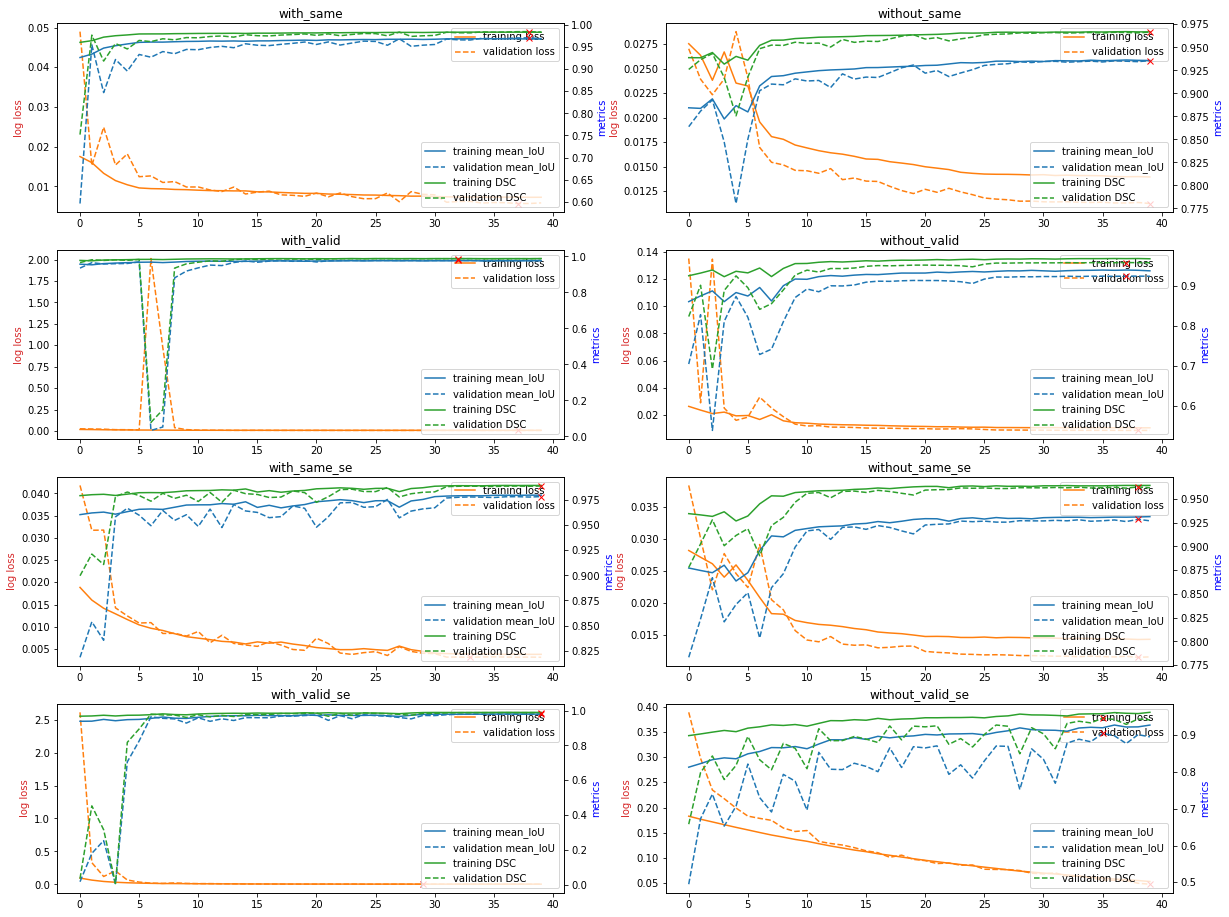

In [25]:
def plot_history(experiments, last=None):
  if last is None:
    last = 0
  
  n_cols = 2
  n_rows = int(np.ceil(len(experiments) / n_cols))
  fig, axis = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
  
  def _plot_key_results(ax, key, results, color, find_min=False, find_max=False):
      training = results[key]
      validation = results['val_{}'.format(key)]
    
      ax.plot(training, label='training {}'.format(key), color=color)
      ax.plot(validation, '--', label='validation {}'.format(key), color=color)
      
      if find_min:
        ax.plot(np.argmin(validation), np.min(validation), marker='x', color='r')
        
      if find_max:
        ax.plot(np.argmax(validation), np.max(validation), marker='x', color='r')
    
  def _plot_results(results, ax, title):
      _plot_key_results(ax, 'loss', results, 'C1', find_min=True)  # see https://matplotlib.org/3.1.1/users/dflt_style_changes.html
      ax.set_ylabel('log loss', color='C3')
      ax.legend()

      ax = ax.twinx()  # instantiate a second axes that shares the same x-axis

      _plot_key_results(ax, 'mean_IoU', results, 'C0', find_max=True)
      _plot_key_results(ax, 'DSC', results, 'C2', find_max=True)
      
      ax.set_ylabel('metrics', color='b')
      ax.legend()

      ax.set_title(title)

  for ax, experiment in zip(axis.ravel(), experiments):
      history = experiment['history']
      results = {
        k: history[k][-last:]
        for k in history.keys()
      }
      
      _plot_results(results, ax, experiment['name'])
    
  fig.savefig(out_path / 'history.png')


plot_history(experiments, last=40)

In [21]:
def save_pred(X, y, pred, ix, model_name, out_folder):
  fig, ax = plt.subplots(1, 2, figsize=(10, 4))

  ax[0].imshow(X[ix, ..., 0], cmap=config.get('image', 'cmap'))
  ax[0].set_title('input image (sample #{})'.format(ix))

  ax[1].imshow(pred[ix].squeeze(), cmap='gray')
  ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
  ax[1].set_title('prediction (ground truth as contour)')

  fig.suptitle('model: {}'.format(model_name))
  fig.savefig(out_folder / '{}.png'.format(ix))
  plt.close(fig)


def do_evaluation(X, y, experiments, save_figs=False, verbose=False):
  for i, experiment in enumerate(experiments):
    _, _, X_test, _, _, y_test = prepare_data(X, y, experiment, verbose=False)
    args = {
      **base_args,
      'padding': experiment['padding'],
      'use_skip_conn': experiment['use_skip_conn'],
      'use_se_block': experiment['use_se_block']
    }  # todo build args from experiment
    model = build_unet(**args)
    model_file = str(get_model_file(experiment['name']))
    pred = do_inference(model, model_file, X_test, config.getint('training', 'batch size'))
    out_folder = out_path / experiment['name']
    
    metrics = [
      {
        'name': 'mean IoU',
        'callback': mean_IoU
      },
      {
        'name': 'DSC',
        'callback': lambda y_true, y_pred: DSC(K.constant(y_true), K.constant(y_pred), axis=[1, 2])
      }
    ]
    experiments[i]['metrics'] = {}
    for metric in metrics:
      experiments[i]['metrics'][metric['name']] = []  # reset
    
    for ix in range(len(X_test)):
      for metric in metrics:
        metric_f = metric['callback']
        metric_val = metric_f(y_test[ix], pred[ix]).numpy()
        experiments[i]['metrics'][metric['name']].append(metric_val)

      if save_figs:
        save_pred(X_test, y_test, pred, ix, experiment['name'], out_folder)
        
    if verbose:
      print('=== experiment # {} / {}: {}'.format(i, len(experiments), experiment['name']))
      print('= metrics on test set (size: {})'.format(len(X_test)))

      for metric_name, metric_vals in experiment['metrics'].items():
        print('= {:>10} ~ mean {:.3f} median {:.3f} std {:.3f}'.format(metric_name, np.mean(metric_vals), np.median(metric_vals), np.std(metric_vals)))


do_evaluation(X, y, experiments, save_figs=True, verbose=True)

=== experiment # 0 / 8: with_same
= metrics on test set (size: 10)
=   mean IoU ~ mean 0.965 median 0.968 std 0.007
=        DSC ~ mean 0.826 median 0.809 std 0.064
=== experiment # 1 / 8: without_same
= metrics on test set (size: 10)
=   mean IoU ~ mean 0.927 median 0.926 std 0.010
=        DSC ~ mean 0.805 median 0.788 std 0.062
=== experiment # 2 / 8: with_valid
= metrics on test set (size: 10)
=   mean IoU ~ mean 0.970 median 0.976 std 0.015
=        DSC ~ mean 0.680 median 0.668 std 0.064
=== experiment # 3 / 8: without_valid
= metrics on test set (size: 10)
=   mean IoU ~ mean 0.914 median 0.917 std 0.023
=        DSC ~ mean 0.664 median 0.655 std 0.059
=== experiment # 4 / 8: with_same_se
= metrics on test set (size: 10)
=   mean IoU ~ mean 0.977 median 0.978 std 0.003
=        DSC ~ mean 0.834 median 0.815 std 0.066
=== experiment # 5 / 8: without_same_se
= metrics on test set (size: 10)
=   mean IoU ~ mean 0.920 median 0.916 std 0.011
=        DSC ~ mean 0.801 median 0.782 std

In [22]:
save_experiments(experiments)